In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from utils.utils_train import train_supervised, train_models_in_threads, test_model
from utils.utils_plots import plot_first_feature
from utils.utils_dataset import balance_dataset, prepare_dataset
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc
#%load_ext line_profiler

In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)

'''
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
'''

"\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Select the columns to normalize - all except 'Class'\ncols_to_normalize = [col for col in data.columns if col != 'Class']\n\n# Apply the normalization\ndata[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])\n"

In [4]:
print(f"{torch.cuda.is_available()}")
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [5]:
# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 1,
    "kappa_join": 0.8,
    "S_0": 1e-10,
    "N_r": 2,
    "c_max": 100,
    "num_samples": 200,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 1,
    "kappa_join": 0.8,
    "S_0": 1e-10,
    "N_r": 2,
    "c_max": 100,
    "num_samples": 200,
    "device": device
}

In [6]:

#display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

In [7]:

import cProfile
%load_ext line_profiler


#plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  



In [8]:
if False:
       data, labels = client_train[0]
       model = local_models[0]

       %lprun -f model.forward\
              -f model.merging_mech.compute_kappa_matrix \
              -f model.merging_mech.merging_mechanism \
              -f model.merging_mech.update_merging_condition \
              -f model.merging_mech.compute_merging_condition\
              -f model.merging_mech.perform_merge\
              train_supervised(model, client_train[0])

In [9]:
def compare_models(model1, model2):
    differences = []

    # Function to find differing indices within the overlapping range
    def find_differing_indices(tensor1, tensor2):
        min_length = min(tensor1.size(0), tensor2.size(0))
        differing = (tensor1[:min_length] != tensor2[:min_length]).nonzero(as_tuple=False)
        if differing.nelement() == 0:
            return "No differences"
        else:
            return differing.view(-1).tolist()  # Flatten and convert to list

    # Compare mu parameter and find differing indices
    mu_equal = torch.equal(model1.mu[:model1.c], model2.mu[:model2.c])
    if not mu_equal:
        differing_indices_mu = find_differing_indices(model1.mu[:model1.c], model2.mu[:model2.c])
        differences.append(f"mu parameter differs at indices {differing_indices_mu}")

    # Compare S parameter and find differing indices
    S_equal = torch.equal(model1.S[:model1.c], model2.S[:model2.c])
    if not S_equal:
        differing_indices_S = find_differing_indices(model1.S[:model1.c], model2.S[:model2.c])
        differences.append(f"S parameter differs at indices {differing_indices_S}")

    # Compare n parameter and find differing indices
    n_equal = torch.equal(model1.n[:model1.c], model2.n[:model2.c])
    if not n_equal:
        differing_indices_n = find_differing_indices(model1.n[:model1.c], model2.n[:model2.c])
        differences.append(f"n parameter differs at indices {differing_indices_n}")

    # Check if there are any differences
    if differences:
        difference_str = ", ".join(differences)
        return False, f"Differences found in: {difference_str}"
    else:
        return True, "Models are identical"


In [10]:
import torch.nn as nn

def run_experiment(num_clients, num_rounds, clients_data, test_data):
        
    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []

    if False:
        # Assuming models and client_data are already defined
        #for client_idx, client_model in enumerate(local_models)
        model = local_models[0]
        pr = cProfile.Profile()
        pr.enable()
        train_supervised(model, client_train[0])
        pr.disable()
        pr.print_stats(sort='cumtime')

    for round in range(num_rounds):
        print(f"--- Communication Round {round + 1} ---")

        aggregated_model = eGAUSSp(**federated_model_params)
        federated_model = eGAUSSp(**federated_model_params)

        # Train local models
        #train_models_in_threads(local_models, clients_data)
        for local_model, client_data in zip(local_models, clients_data):
            train_supervised(local_model, client_data)

            all_scores, pred_max, _ = test_model(local_model, test_data)
            binary = calculate_metrics(pred_max, test_data, "binary")
            roc_auc = calculate_roc_auc(all_scores, test_data)
            print(f"Test Metrics: {binary}")
            print(f"Test ROC AUC: {roc_auc}")
            plot_confusion_matrix(pred_max, test_data)

        # Update federated model with local models
        for client_idx, client_model in enumerate(local_models):
            #client_model.federal_agent.federated_merging()
            print(f"Updating agreggated model with client {client_idx + 1}")

            aggregated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)
            print(f"Number of agreggated clusters after transfer = {sum(aggregated_model.n[0:aggregated_model.c]> aggregated_model.kappa_n)}")
            aggregated_model.federal_agent.federated_merging()
            print(f"Number of federated clusters after merging = {sum(aggregated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

            
                   
        #client_model.score = 0*client_model.score  
        #aggregated_model.S_glo = client_model.S_glo
        #aggregated_model.mu_glo = client_model.mu_glo     


        if round>1:
            with torch.no_grad():
                aggregated_model.S = nn.Parameter(aggregated_model.S/2)
                aggregated_model.n = nn.Parameter(aggregated_model.n/2)

                aggregated_model.S_glo = aggregated_model.S_glo/2
                aggregated_model.n_glo = aggregated_model.n_glo/2

        # New code for comparison using the updated compare_models function
        #are_models_same, comparison_message = compare_models(client_model, aggregated_model)
        #print(f"Comparison details: {comparison_message}")

        # Update federated model with local models
        print(f"Updating federated model with agreggated model")
        federated_model = aggregated_model #.federal_agent.merge_model_privately(aggregated_model, federated_model.kappa_n)
        print(f"Number of federated clusters after transfer = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

 
        # Perform federated merging and removal mechanism on the federated model
        if any(federated_model.n[0:federated_model.c]> federated_model.kappa_n):

            # Evaluate federated model
            all_scores_fed, pred_max_fed, _ = test_model(federated_model, test_data)
            binary_fed = calculate_metrics(pred_max_fed, test_data, "binary")
            roc_auc_fed = calculate_roc_auc(all_scores_fed, test_data)
            print(f"Test Metrics: {binary_fed}")
            print(f"Test ROC AUC: {roc_auc_fed}")

            plot_confusion_matrix(pred_max_fed, test_data)

            # Append metrics to the list
            round_metrics.append({
                'round': round + 1,
                'clusters': federated_model.c,
                'binary': binary_fed,
                'roc_auc': roc_auc_fed
            })
            
        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]  
        # Return the updated federated model to each client
        for client_idx in range(len(local_models)):
            print(f"Returning updated model to client {client_idx + 1}")
            #local_models[client_idx] = federated_model
            
            local_models[client_idx].federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
            #local_models[client_idx].score = torch.zeros_like(local_models[client_idx].score)

            '''
            # Return the updated federated model to each client
            for client_idx, client_model in enumerate(local_models):
                print(f"Returning updated model to client {client_idx + 1}")
                client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
                client_model.federal_agent.federated_merging()
            '''
            
        print(f"--- End of Round {round + 1} ---\n")
        if  round == (num_rounds-1):
            plot_first_feature(test_data, model=federated_model, num_sigma=2, N_max = federated_model.kappa_n)   
    
    # After all rounds
    print("All Rounds Completed. Metrics Collected:")
    for metric in round_metrics:
        print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
        #print(f"                         Weighted: {metric['weighted']}")


    return round_metrics

Client 1: {0: 105, 1: 125}
Client 2: {0: 124, 1: 105}
Client 3: {0: 116, 1: 113}
Test Set: {0: 147, 1: 149}

Combined Number of Samples per Class:
Class 0: 492 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 984
Running experiment with 3 clients and data configuration 1
--- Communication Round 1 ---
Evolving has been enabled.
Evolving has been disabled.


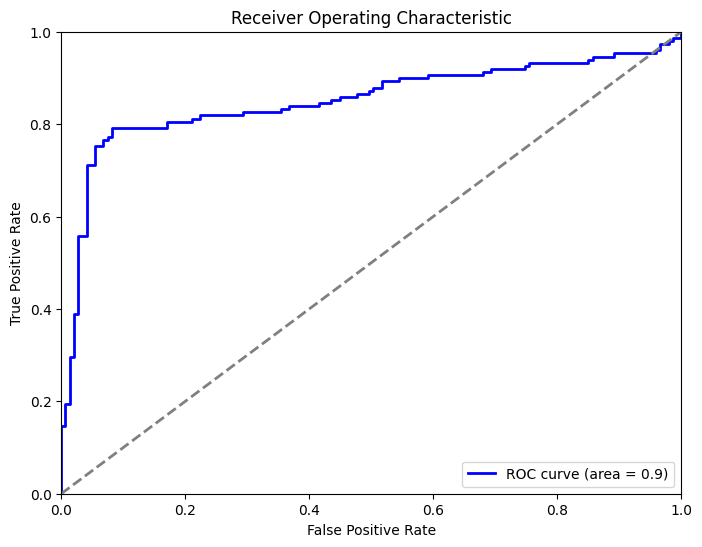

Test Metrics: {'accuracy': 0.8141891891891891, 'precision': 0.821917808219178, 'recall': 0.8053691275167785, 'f1_score': 0.8135593220338982}
Test ROC AUC: 0.8523033374423595


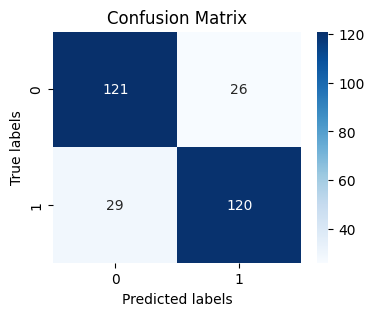

Evolving has been enabled.
Evolving has been disabled.


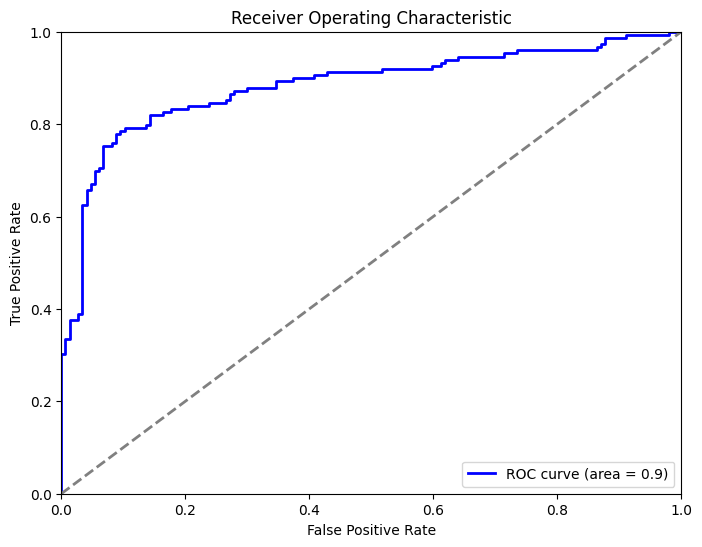

Test Metrics: {'accuracy': 0.581081081081081, 'precision': 0.5478927203065134, 'recall': 0.959731543624161, 'f1_score': 0.6975609756097559}
Test ROC AUC: 0.8831210336483587


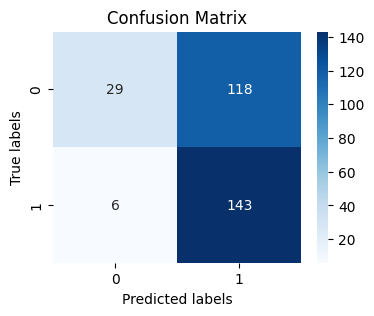

Evolving has been enabled.
Evolving has been disabled.


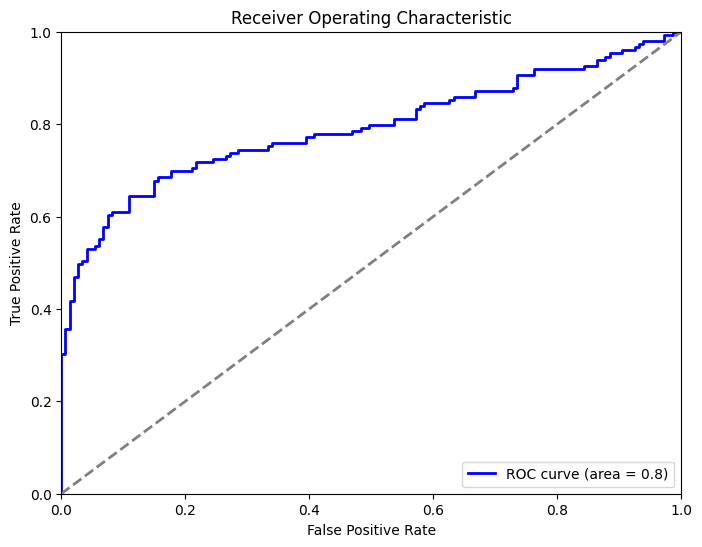

Test Metrics: {'accuracy': 0.5777027027027027, 'precision': 0.5504201680672269, 'recall': 0.8791946308724832, 'f1_score': 0.6770025839793282}
Test ROC AUC: 0.79185499703237


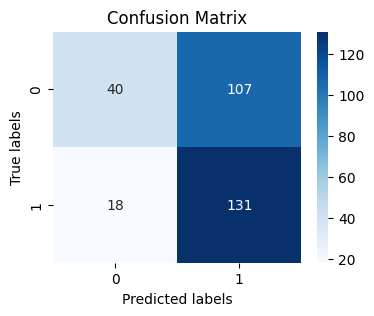

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 26
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 52
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 61
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 45
Evolving has been disabled.


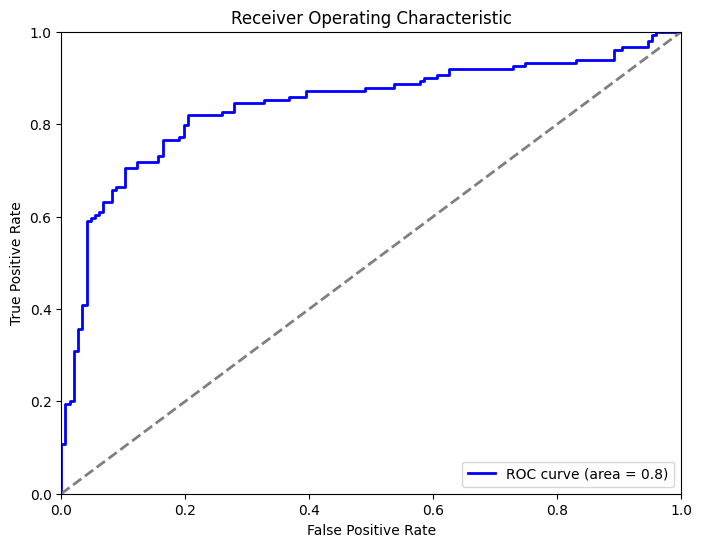

Test Metrics: {'accuracy': 0.7972972972972973, 'precision': 0.8677685950413223, 'recall': 0.7046979865771812, 'f1_score': 0.7777777777777777}
Test ROC AUC: 0.8414829018855866


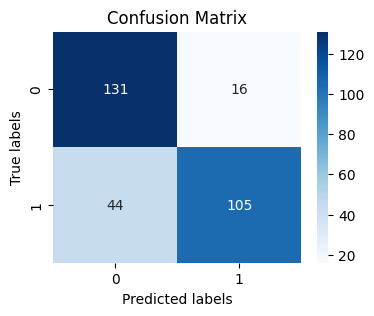

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 1 ---

--- Communication Round 2 ---
Evolving has been enabled.
Evolving has been disabled.


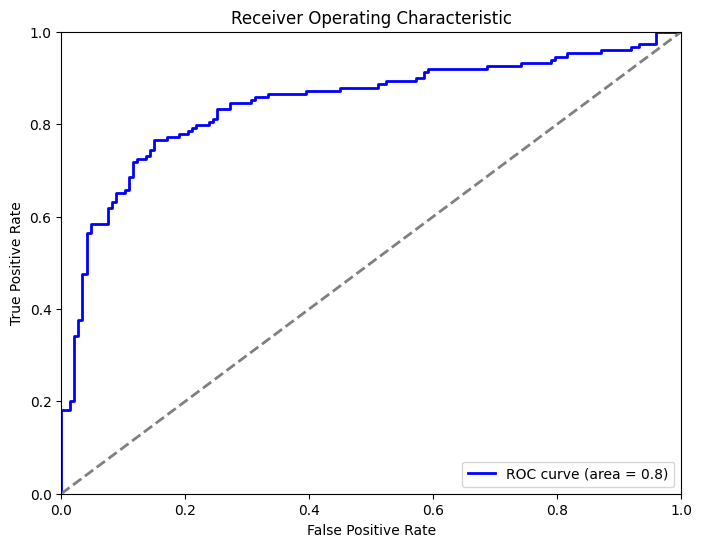

Test Metrics: {'accuracy': 0.7837837837837838, 'precision': 0.8571428571428571, 'recall': 0.6845637583892618, 'f1_score': 0.7611940298507462}
Test ROC AUC: 0.8454549605076929


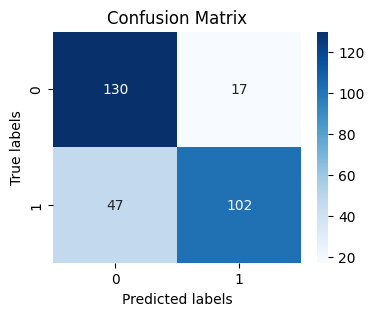

Evolving has been enabled.
Evolving has been disabled.


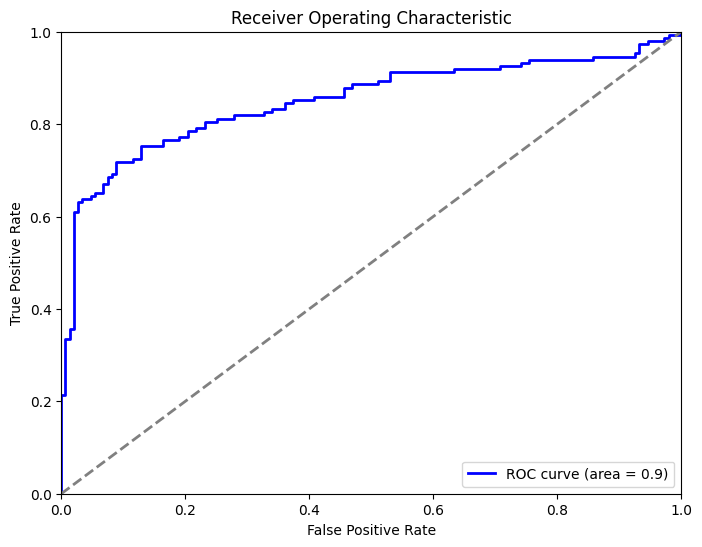

Test Metrics: {'accuracy': 0.7905405405405406, 'precision': 0.9065420560747663, 'recall': 0.6510067114093959, 'f1_score': 0.7578125000000001}
Test ROC AUC: 0.8514358763639683


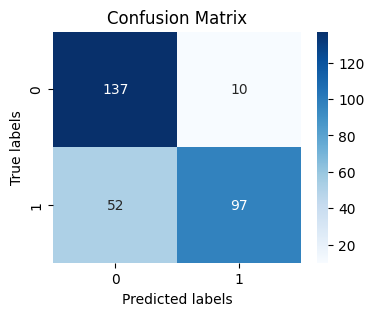

Evolving has been enabled.
Evolving has been disabled.


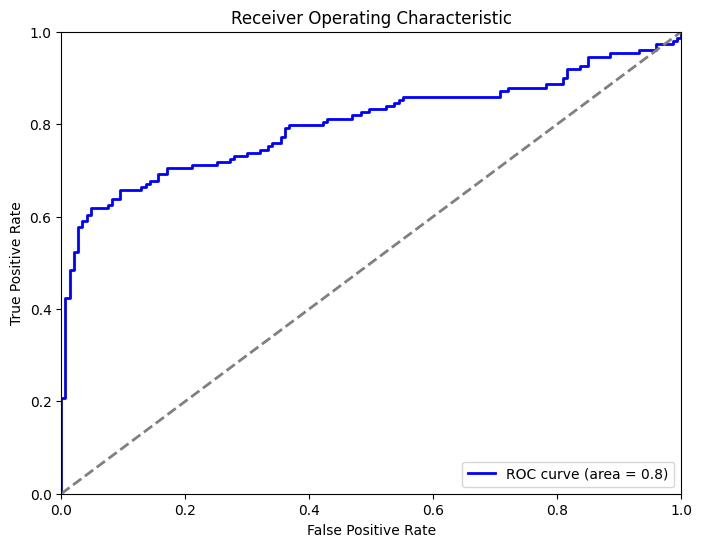

Test Metrics: {'accuracy': 0.7804054054054054, 'precision': 0.875, 'recall': 0.6577181208053692, 'f1_score': 0.7509578544061303}
Test ROC AUC: 0.8018992832032141


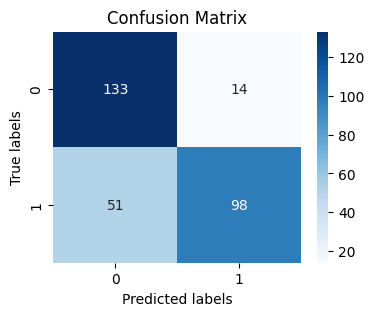

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 49
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 92
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 130
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 127
Evolving has been disabled.


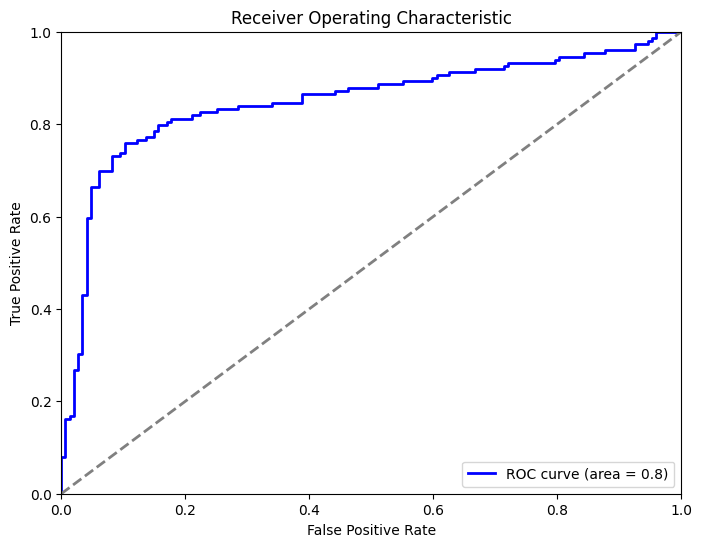

Test Metrics: {'accuracy': 0.8277027027027027, 'precision': 0.8828125, 'recall': 0.7583892617449665, 'f1_score': 0.8158844765342961}
Test ROC AUC: 0.8498379217458796


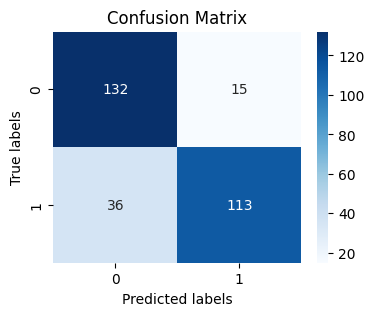

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 2 ---

--- Communication Round 3 ---
Evolving has been enabled.
Evolving has been disabled.


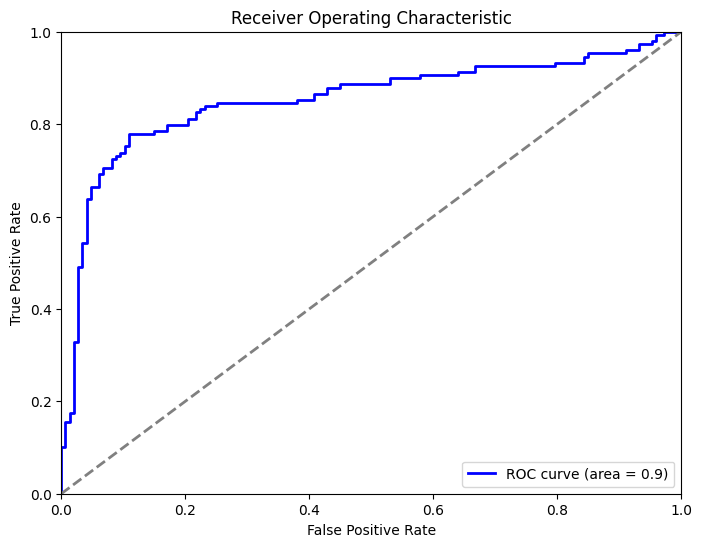

Test Metrics: {'accuracy': 0.8277027027027027, 'precision': 0.8769230769230769, 'recall': 0.7651006711409396, 'f1_score': 0.8172043010752689}
Test ROC AUC: 0.8536273569830618


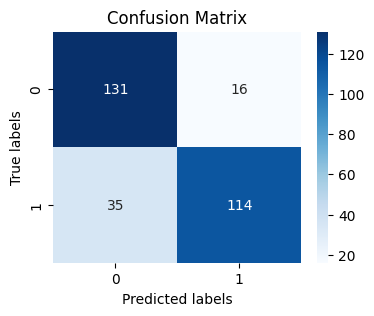

Evolving has been enabled.
Evolving has been disabled.


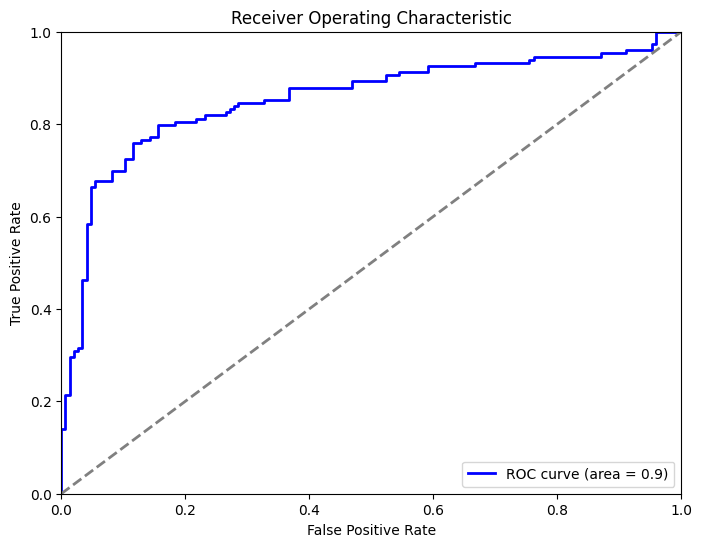

Test Metrics: {'accuracy': 0.8006756756756757, 'precision': 0.875, 'recall': 0.7046979865771812, 'f1_score': 0.7806691449814126}
Test ROC AUC: 0.8553622791398439


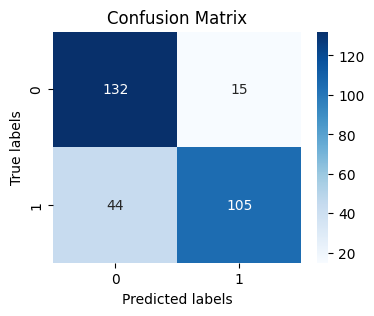

Evolving has been enabled.
Evolving has been disabled.


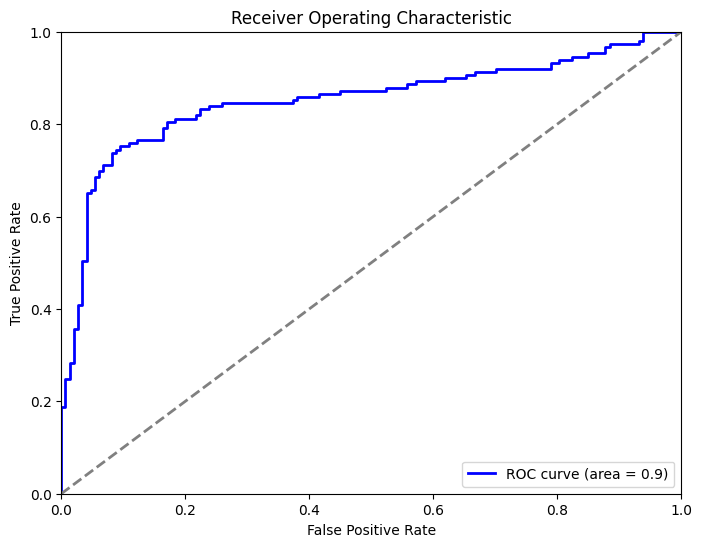

Test Metrics: {'accuracy': 0.8277027027027027, 'precision': 0.8951612903225806, 'recall': 0.7449664429530202, 'f1_score': 0.8131868131868132}
Test ROC AUC: 0.8529881751358261


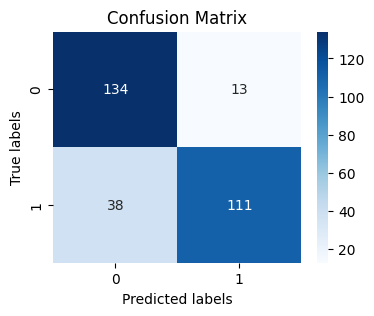

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 128
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 251
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 319
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 200
Evolving has been disabled.


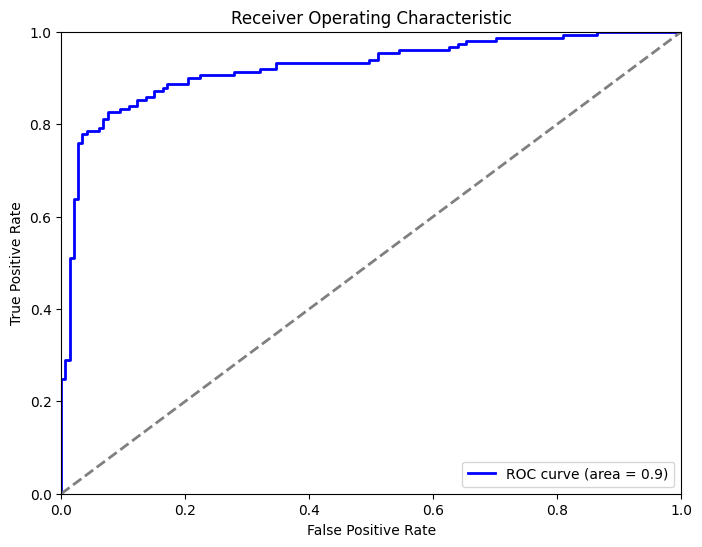

Test Metrics: {'accuracy': 0.8716216216216216, 'precision': 0.9512195121951219, 'recall': 0.785234899328859, 'f1_score': 0.8602941176470589}
Test ROC AUC: 0.9233438341779666


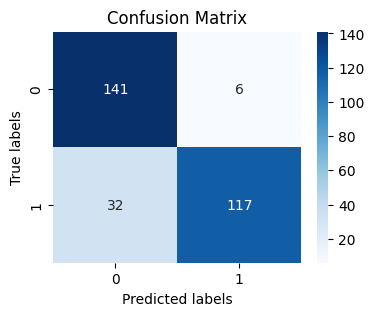

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 3 ---

--- Communication Round 4 ---
Evolving has been enabled.
Evolving has been disabled.


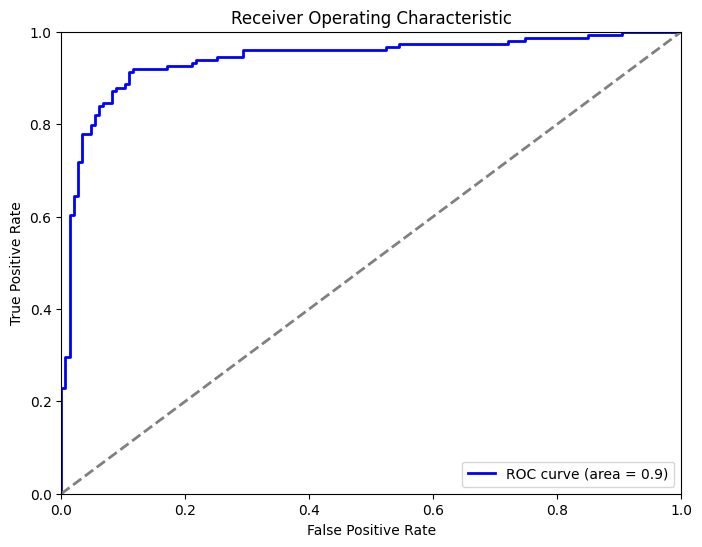

Test Metrics: {'accuracy': 0.8648648648648649, 'precision': 0.943089430894309, 'recall': 0.7785234899328859, 'f1_score': 0.8529411764705882}
Test ROC AUC: 0.9411039583618683


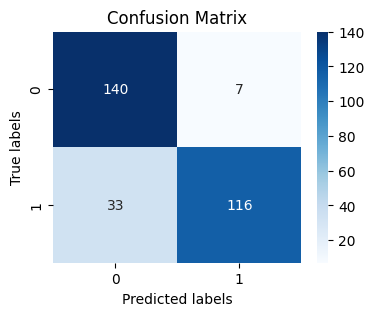

Evolving has been enabled.
Evolving has been disabled.


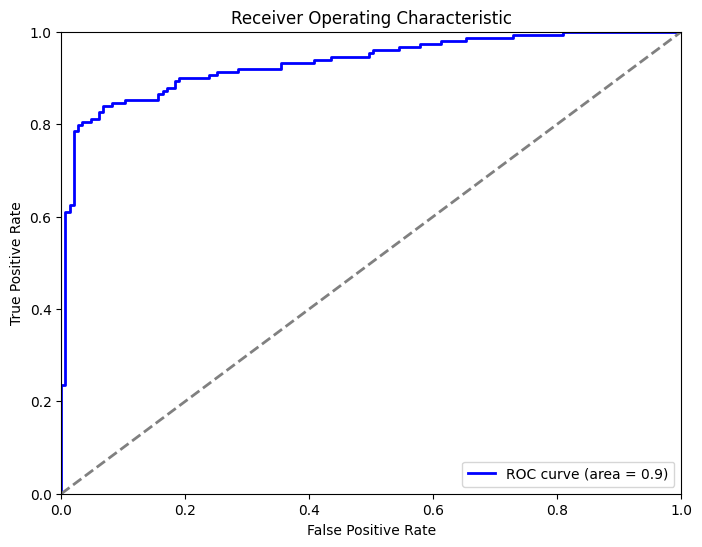

Test Metrics: {'accuracy': 0.8783783783783784, 'precision': 0.9747899159663865, 'recall': 0.7785234899328859, 'f1_score': 0.8656716417910447}
Test ROC AUC: 0.9333424645025796


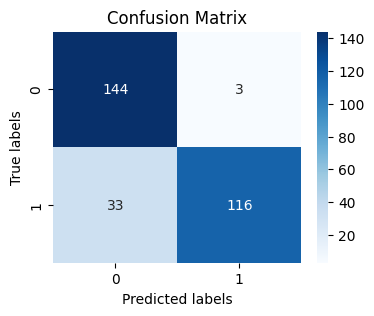

Evolving has been enabled.
Evolving has been disabled.


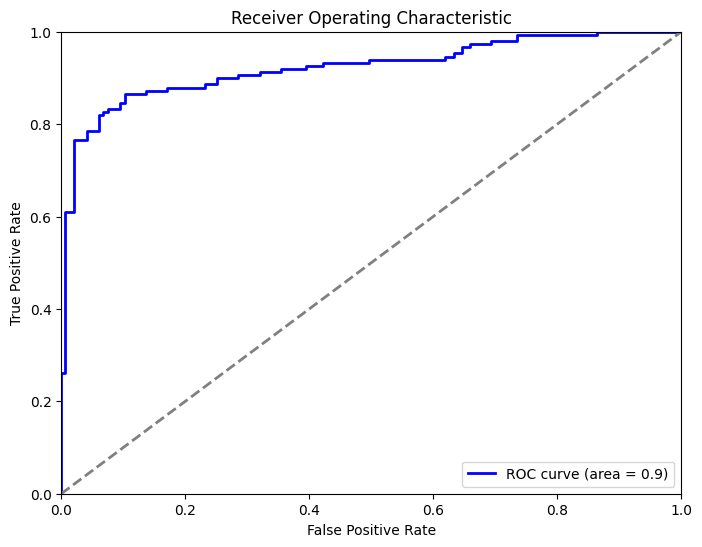

Test Metrics: {'accuracy': 0.8716216216216216, 'precision': 0.9743589743589743, 'recall': 0.7651006711409396, 'f1_score': 0.8571428571428571}
Test ROC AUC: 0.9232525224855042


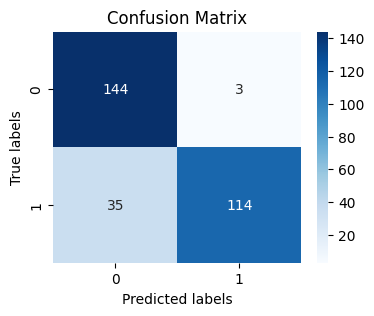

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 200
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 380
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 398
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 200
Evolving has been disabled.


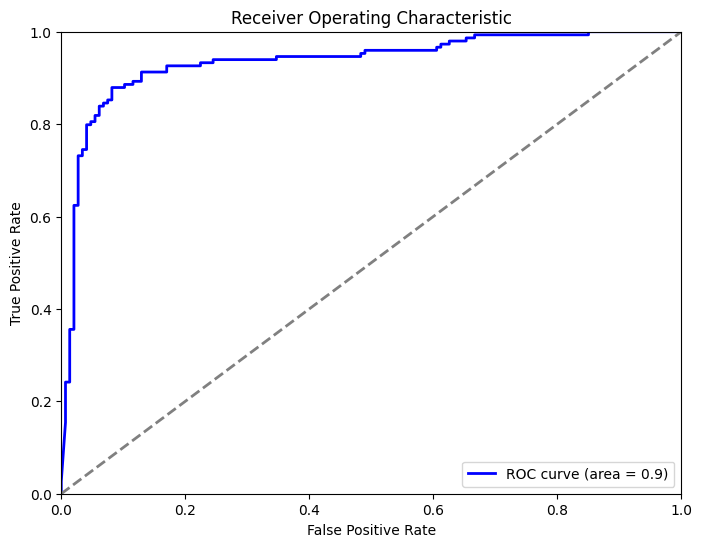

Test Metrics: {'accuracy': 0.8851351351351351, 'precision': 0.9136690647482014, 'recall': 0.8523489932885906, 'f1_score': 0.8819444444444444}
Test ROC AUC: 0.9356480847372507


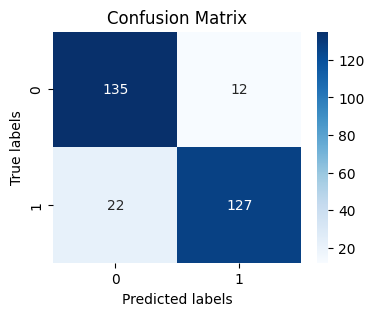

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 4 ---

--- Communication Round 5 ---
Evolving has been enabled.
Evolving has been disabled.


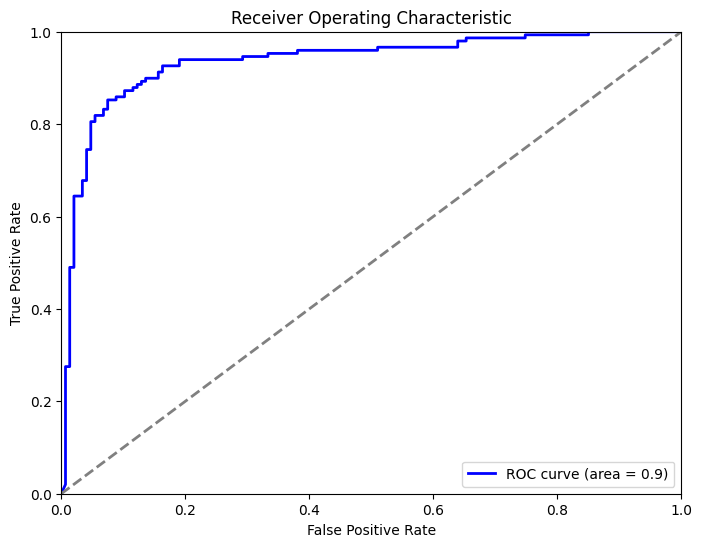

Test Metrics: {'accuracy': 0.8851351351351351, 'precision': 0.9136690647482014, 'recall': 0.8523489932885906, 'f1_score': 0.8819444444444444}
Test ROC AUC: 0.9361502990457928


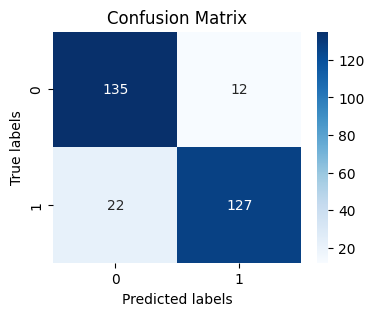

Evolving has been enabled.
Evolving has been disabled.


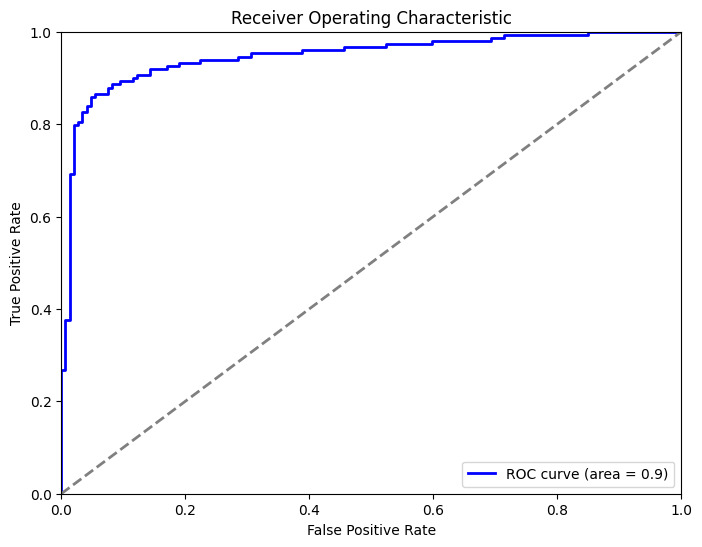

Test Metrics: {'accuracy': 0.9054054054054054, 'precision': 0.9481481481481482, 'recall': 0.8590604026845637, 'f1_score': 0.9014084507042253}
Test ROC AUC: 0.9480893028352281


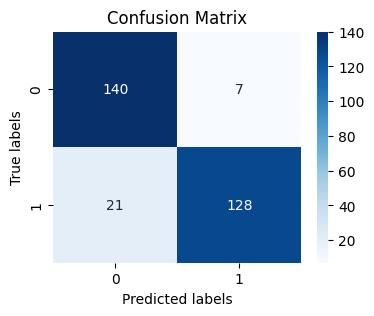

Evolving has been enabled.
Evolving has been disabled.


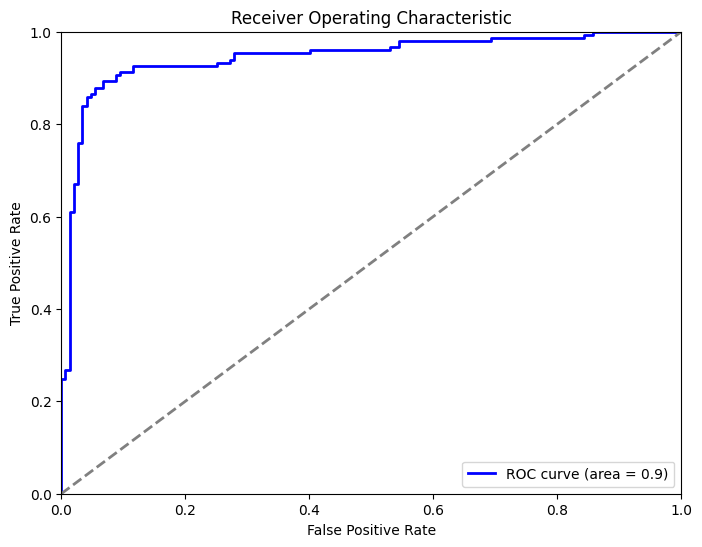

Test Metrics: {'accuracy': 0.9087837837837838, 'precision': 0.9357142857142857, 'recall': 0.8791946308724832, 'f1_score': 0.9065743944636678}
Test ROC AUC: 0.9458065105236726


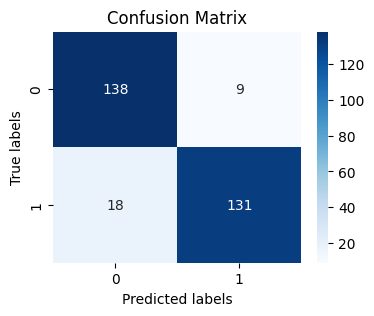

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 202
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 384
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 402
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 200
Evolving has been disabled.


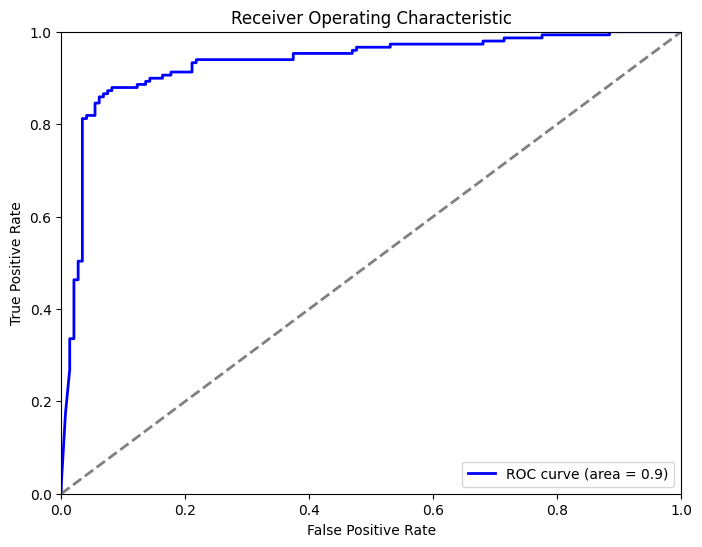

Test Metrics: {'accuracy': 0.8783783783783784, 'precision': 0.8741721854304636, 'recall': 0.8859060402684564, 'f1_score': 0.8800000000000001}
Test ROC AUC: 0.9332283248870017


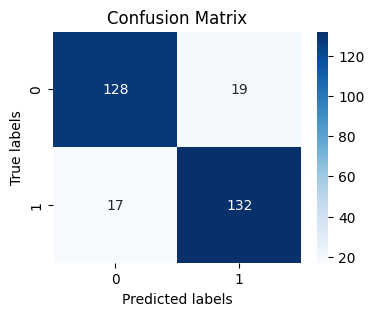

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 5 ---

--- Communication Round 6 ---
Evolving has been enabled.
Evolving has been disabled.


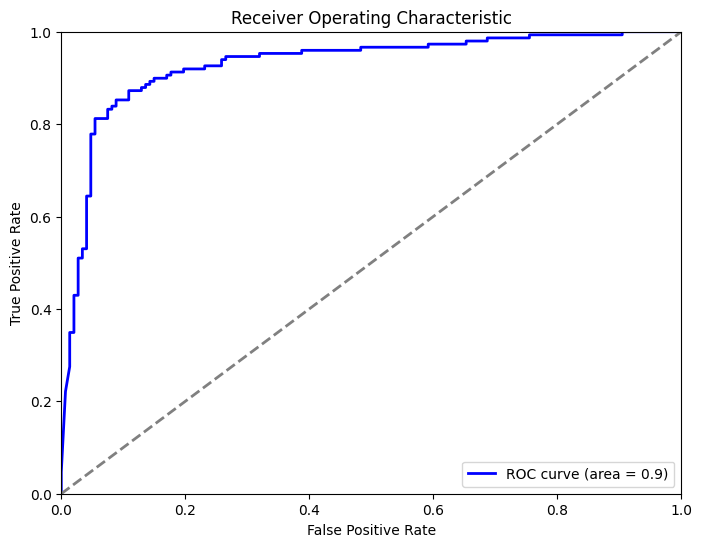

Test Metrics: {'accuracy': 0.8716216216216216, 'precision': 0.87248322147651, 'recall': 0.87248322147651, 'f1_score': 0.87248322147651}
Test ROC AUC: 0.9287312240332376


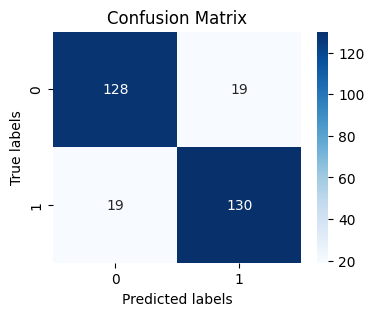

Evolving has been enabled.
Evolving has been disabled.


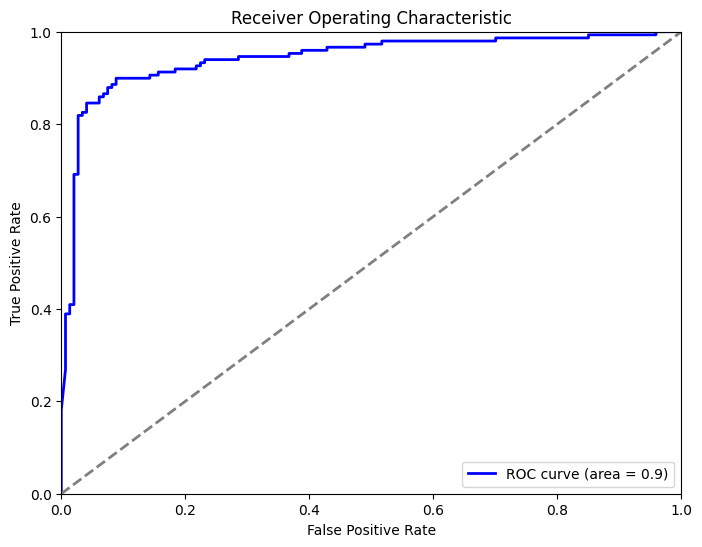

Test Metrics: {'accuracy': 0.8986486486486487, 'precision': 0.9280575539568345, 'recall': 0.8657718120805369, 'f1_score': 0.8958333333333333}
Test ROC AUC: 0.9430899876729214


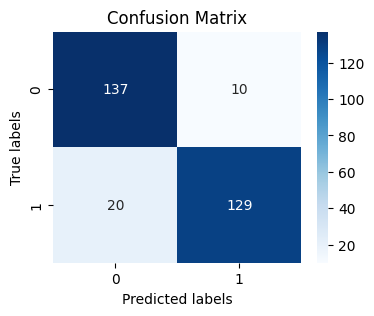

Evolving has been enabled.
Evolving has been disabled.


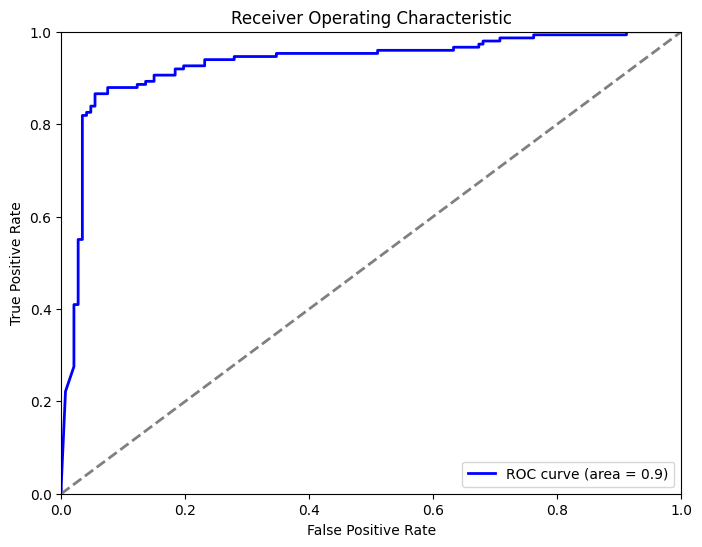

Test Metrics: {'accuracy': 0.8851351351351351, 'precision': 0.891156462585034, 'recall': 0.8791946308724832, 'f1_score': 0.8851351351351352}
Test ROC AUC: 0.9319271332694151


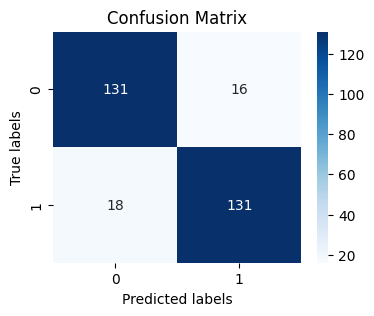

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 203
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 316
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 399
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 196
Evolving has been disabled.


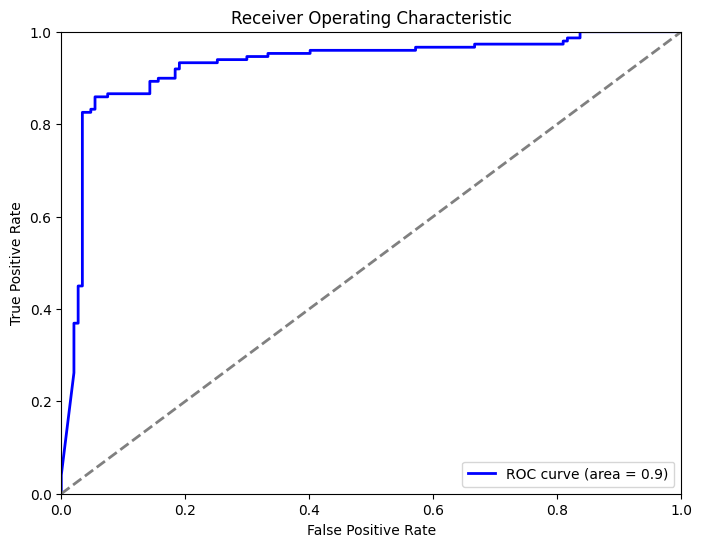

Test Metrics: {'accuracy': 0.8716216216216216, 'precision': 0.8775510204081632, 'recall': 0.8657718120805369, 'f1_score': 0.8716216216216215}
Test ROC AUC: 0.9280692142628864


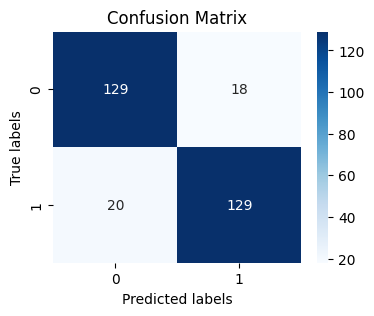

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 6 ---

--- Communication Round 7 ---
Evolving has been enabled.
Evolving has been disabled.


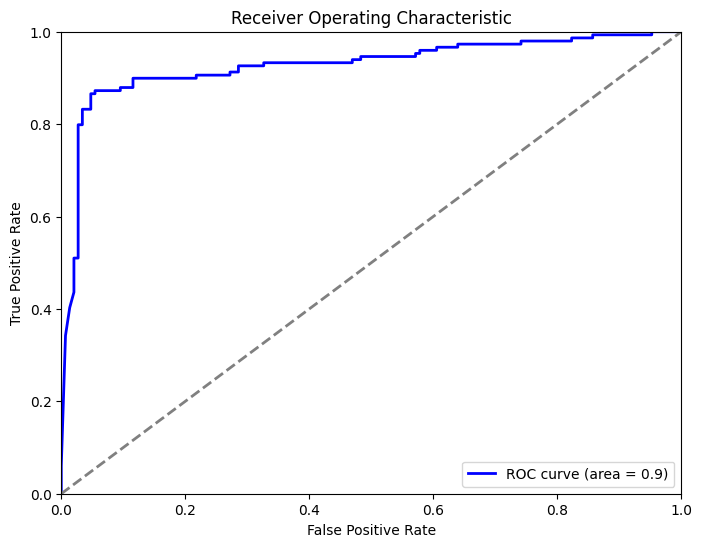

Test Metrics: {'accuracy': 0.9087837837837838, 'precision': 0.9485294117647058, 'recall': 0.8657718120805369, 'f1_score': 0.9052631578947368}
Test ROC AUC: 0.9280007304935398


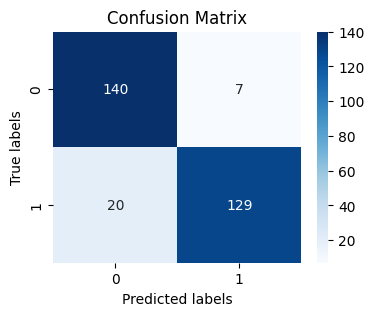

Evolving has been enabled.
Evolving has been disabled.


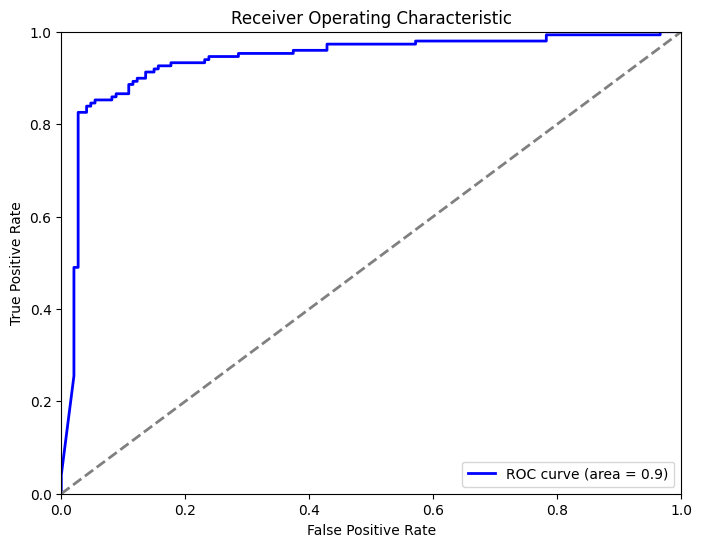

Test Metrics: {'accuracy': 0.8986486486486487, 'precision': 0.9473684210526315, 'recall': 0.8456375838926175, 'f1_score': 0.8936170212765957}
Test ROC AUC: 0.938501575126695


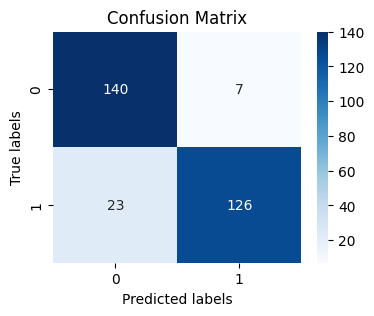

Evolving has been enabled.
Evolving has been disabled.


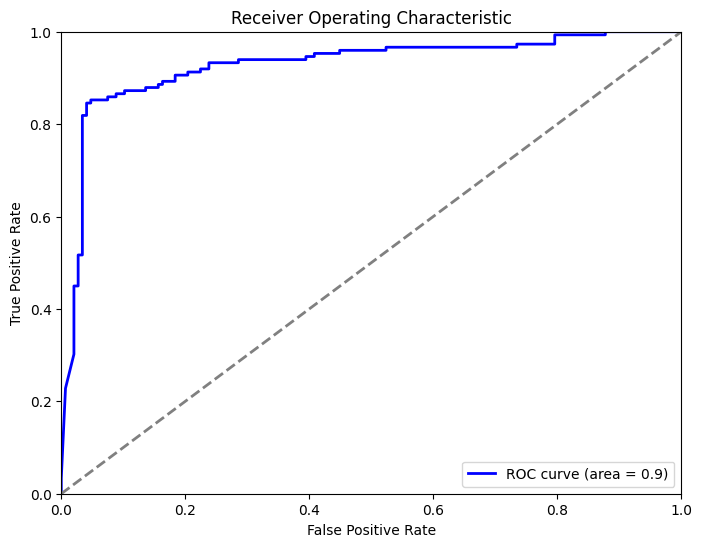

Test Metrics: {'accuracy': 0.8851351351351351, 'precision': 0.896551724137931, 'recall': 0.87248322147651, 'f1_score': 0.8843537414965987}
Test ROC AUC: 0.9277496233392686


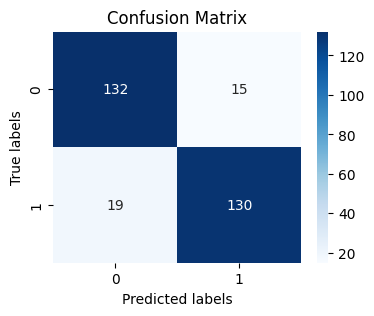

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 197
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 307
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 393
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 183
Evolving has been disabled.


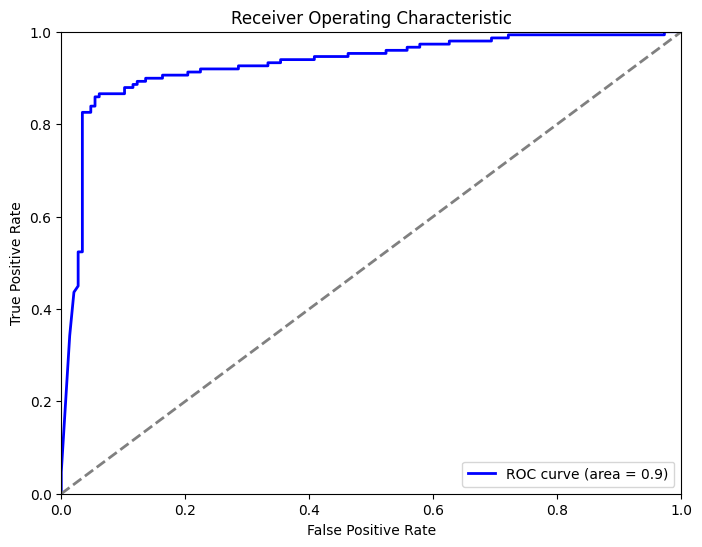

Test Metrics: {'accuracy': 0.8817567567567568, 'precision': 0.8958333333333334, 'recall': 0.8657718120805369, 'f1_score': 0.8805460750853242}
Test ROC AUC: 0.9300552435739398


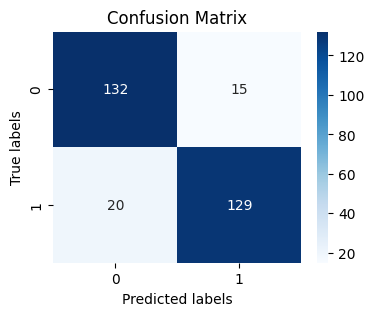

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 7 ---

--- Communication Round 8 ---
Evolving has been enabled.
Evolving has been disabled.


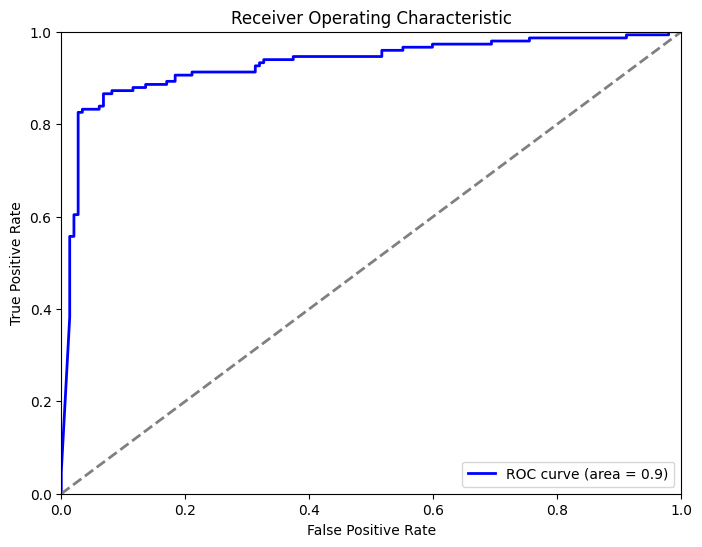

Test Metrics: {'accuracy': 0.8986486486486487, 'precision': 0.9612403100775194, 'recall': 0.8322147651006712, 'f1_score': 0.8920863309352518}
Test ROC AUC: 0.9305118020362507


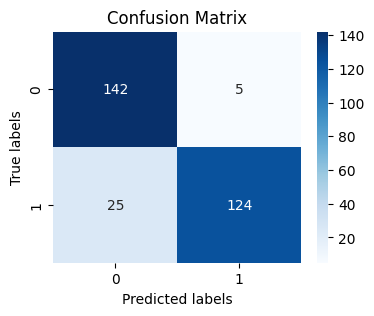

Evolving has been enabled.
Evolving has been disabled.


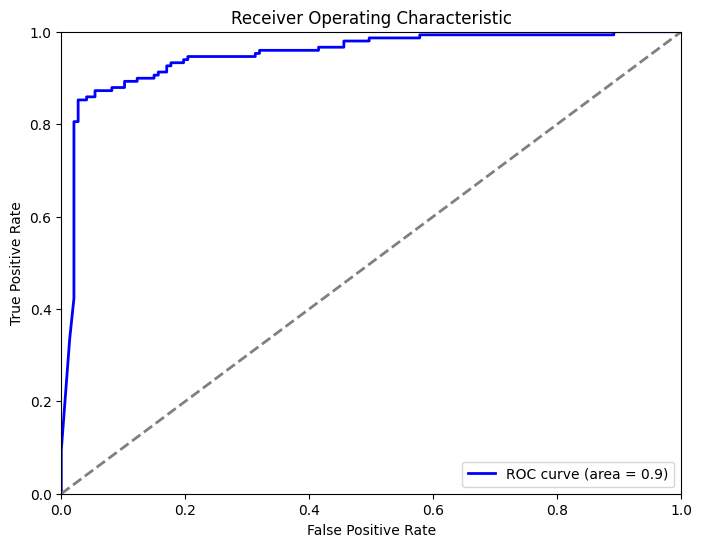

Test Metrics: {'accuracy': 0.9087837837837838, 'precision': 0.9621212121212122, 'recall': 0.8523489932885906, 'f1_score': 0.9039145907473309}
Test ROC AUC: 0.9494818061452769


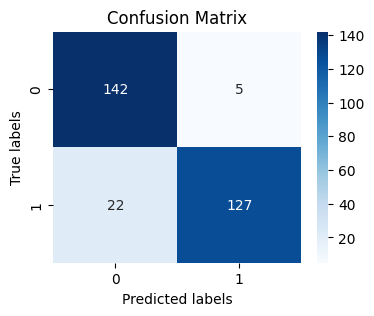

Evolving has been enabled.
Evolving has been disabled.


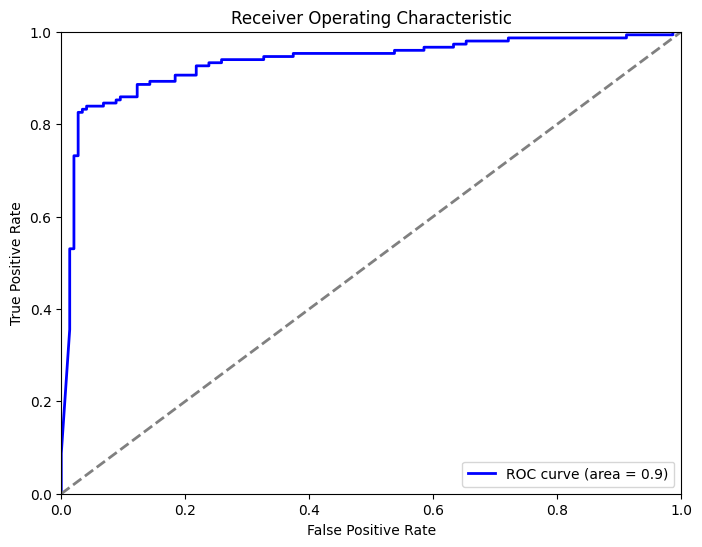

Test Metrics: {'accuracy': 0.8918918918918919, 'precision': 0.9398496240601504, 'recall': 0.8389261744966443, 'f1_score': 0.8865248226950355}
Test ROC AUC: 0.9340729580422772


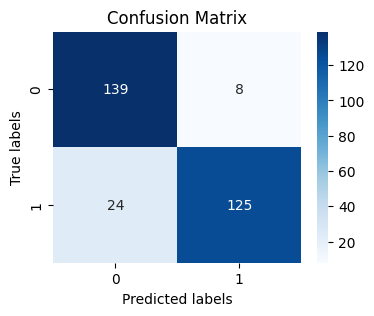

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 186
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 302
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 384
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 169
Evolving has been disabled.


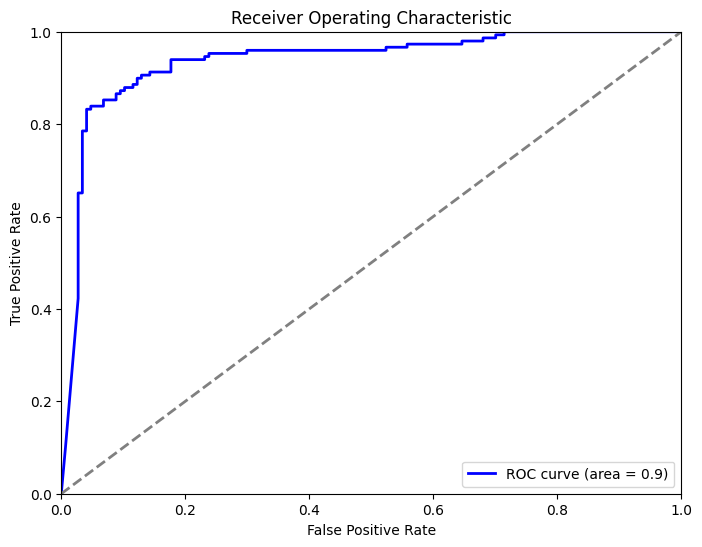

Test Metrics: {'accuracy': 0.8885135135135135, 'precision': 0.9202898550724637, 'recall': 0.8523489932885906, 'f1_score': 0.8850174216027874}
Test ROC AUC: 0.9379308770488061


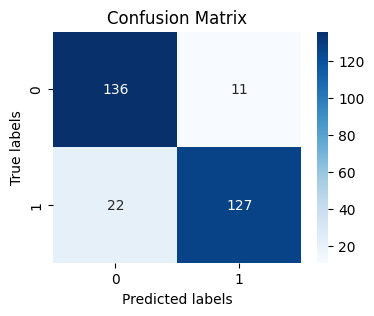

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 8 ---

--- Communication Round 9 ---
Evolving has been enabled.
Evolving has been disabled.


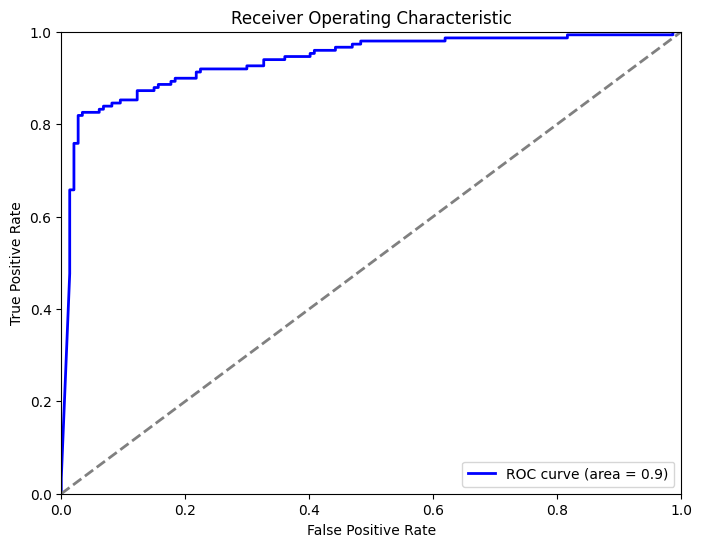

Test Metrics: {'accuracy': 0.8716216216216216, 'precision': 0.9663865546218487, 'recall': 0.7718120805369127, 'f1_score': 0.8582089552238806}
Test ROC AUC: 0.9373145231246861


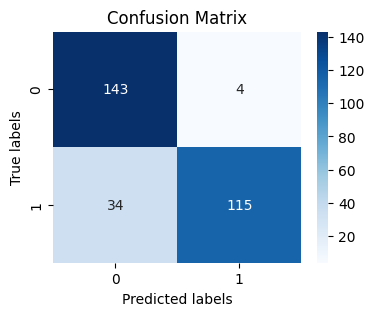

Evolving has been enabled.
Evolving has been disabled.


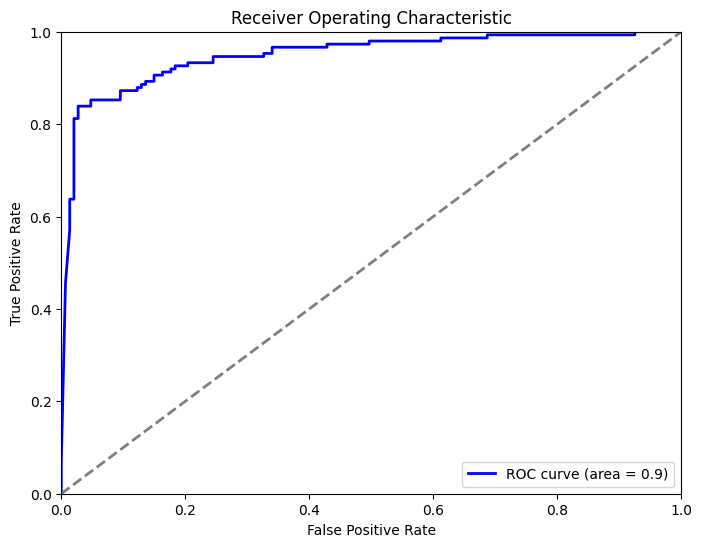

Test Metrics: {'accuracy': 0.902027027027027, 'precision': 0.9477611940298507, 'recall': 0.8523489932885906, 'f1_score': 0.8975265017667845}
Test ROC AUC: 0.949070903529197


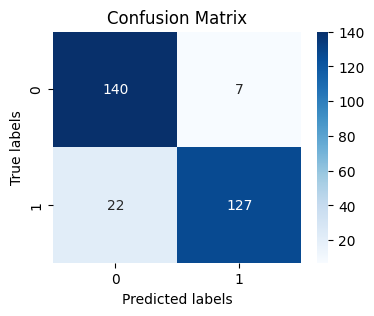

Evolving has been enabled.
Evolving has been disabled.


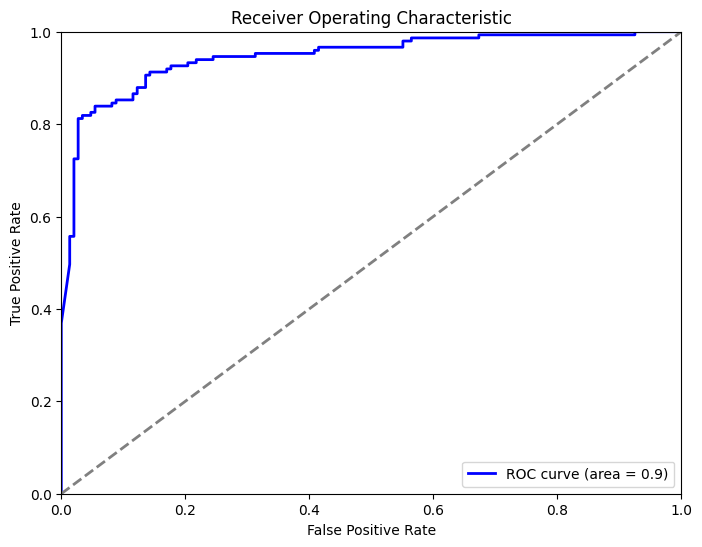

Test Metrics: {'accuracy': 0.8918918918918919, 'precision': 0.9398496240601504, 'recall': 0.8389261744966443, 'f1_score': 0.8865248226950355}
Test ROC AUC: 0.9459434780623658


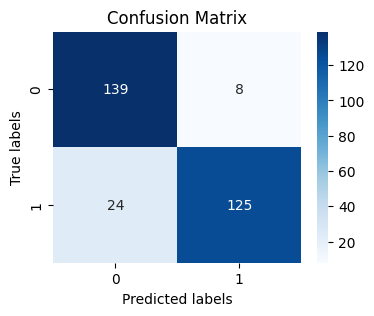

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 172
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 317
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 370
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 177
Evolving has been disabled.


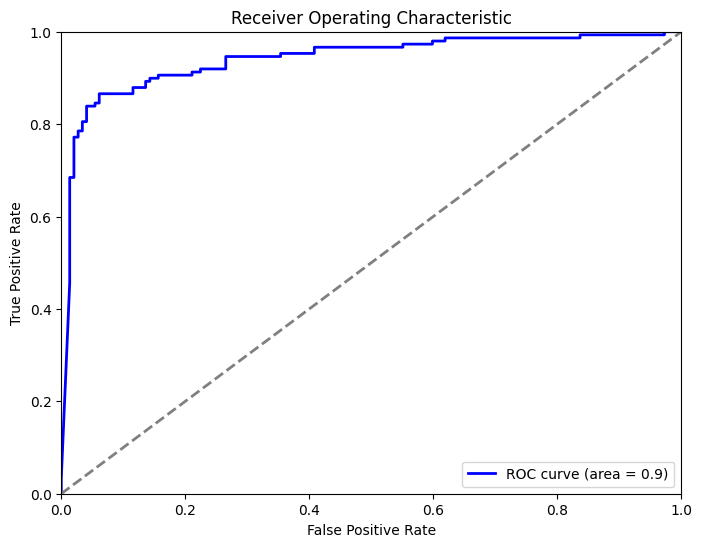

Test Metrics: {'accuracy': 0.8885135135135135, 'precision': 0.953125, 'recall': 0.8187919463087249, 'f1_score': 0.8808664259927798}
Test ROC AUC: 0.9409213349769437


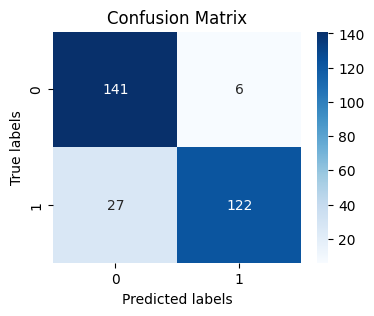

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 9 ---

--- Communication Round 10 ---
Evolving has been enabled.
Evolving has been disabled.


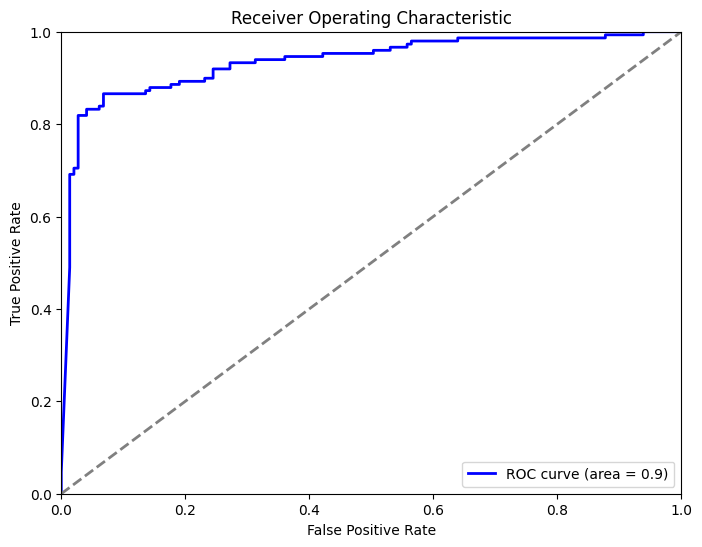

Test Metrics: {'accuracy': 0.8952702702702703, 'precision': 0.9682539682539683, 'recall': 0.8187919463087249, 'f1_score': 0.8872727272727273}
Test ROC AUC: 0.9353056658905172


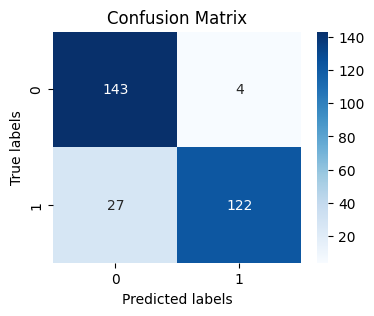

Evolving has been enabled.
Evolving has been disabled.


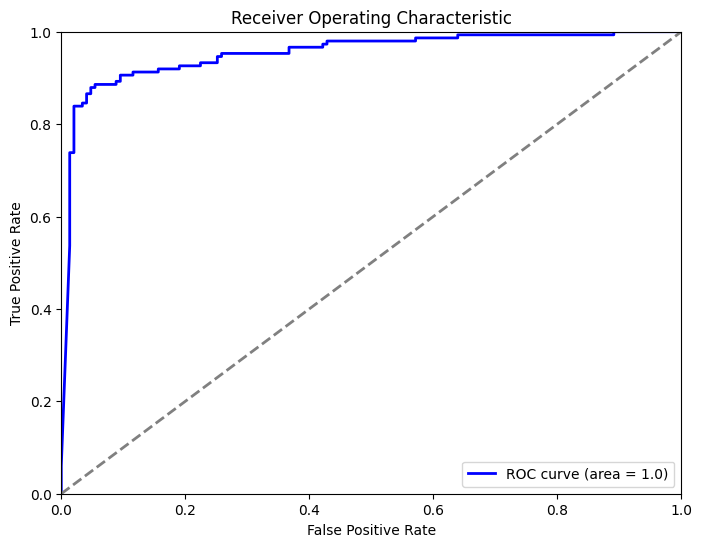

Test Metrics: {'accuracy': 0.9054054054054054, 'precision': 0.9763779527559056, 'recall': 0.8322147651006712, 'f1_score': 0.8985507246376812}
Test ROC AUC: 0.9535680043829612


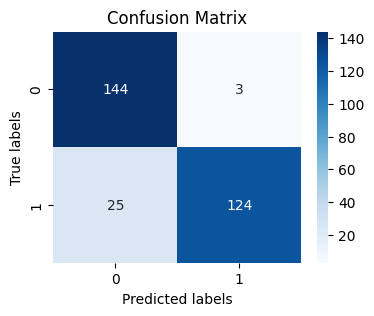

Evolving has been enabled.
Evolving has been disabled.


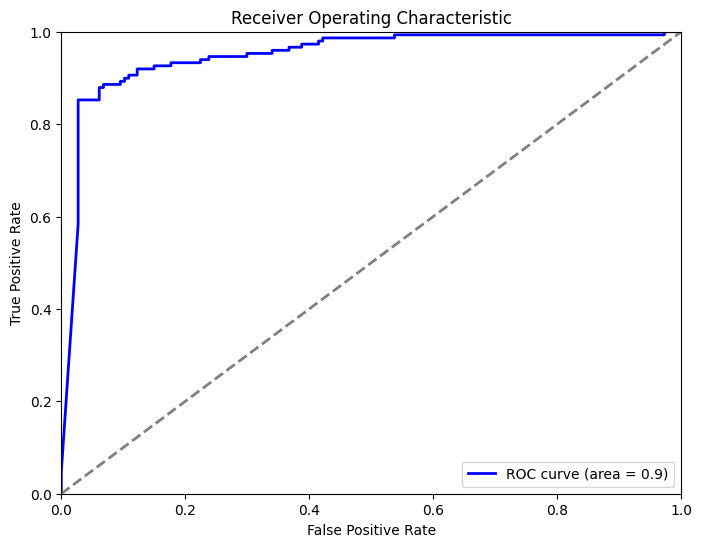

Test Metrics: {'accuracy': 0.9087837837837838, 'precision': 0.9692307692307692, 'recall': 0.8456375838926175, 'f1_score': 0.9032258064516129}
Test ROC AUC: 0.9491850431447747


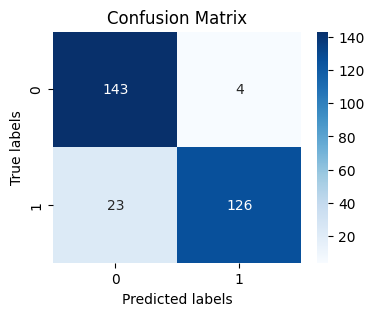

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 180
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 325
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 364


In [11]:
# List of client counts and data configuration indices
client_counts = [3, 10]
data_config_indices = [1,2, 3]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 10
experiments = []
# Running the experiment
for num_clients in client_counts:
    for data_config_index in data_config_indices:
        if data_config_index == 1:
            proportion = 1
            data_partitioned = balance_dataset(data, proportion)
            X = data_partitioned.iloc[:, :-1].values
            y = data_partitioned.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 
        if data_config_index == 2:
            proportion = 10
            data_partitioned = balance_dataset(data, proportion)
            X = data_partitioned.iloc[:, :-1].values
            y = data_partitioned.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 
        if data_config_index == 3:
            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 

        display_dataset_split(client_train, test_data)

        print(f"Running experiment with {num_clients} clients and data configuration {data_config_index}")
        metrics = run_experiment(num_clients, num_rounds, client_train, test_data)
        experiments.append(metrics)

In [ ]:
print("All Rounds Completed. Metrics Collected:")
for metric in metrics:
    print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
    print(f"                         Weighted: {metric['weighted']}")

In [ ]:
'''
for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        #print(f"Number of client {client_idx + 1} clusters before merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        #client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} after merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        federated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)

print(f"Number of clusters after transfer = {federated_model.c}")
'''

In [ ]:
'''
federated_model.federal_agent.federated_merging()
federated_model.removal_mech.removal_mechanism()
print(f"Number of clusters after merging = {federated_model.c}")
'''

In [ ]:

'''
print(f"\nTesting federated model")   

all_scores, pred_max, _ = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data, "binary")
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
print(f"Test ROC AUC: {roc_auc}")

plot_confusion_matrix(pred_max, test_data)
'''

In [ ]:

'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix values
tn = 135
fn = 10
tp = 132
fp = 19

# Creating the confusion matrix
y_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class
y_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions

# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(accuracy, precision, recall, f1)
'''